# **Exploratory Data Analysis**
---

In [25]:
import pandas as pd
import seaborn as sns

import sys
sys.path.append("..")
from src.support_eda import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
pd.set_option('display.max_columns', None)

Cargamos el conjunto de datos que se va a usar durante este proyecto:

In [27]:
df = pd.read_csv("../datos/Global_Superstore.csv")

In [28]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


## Nulos y Duplicados

Comprobemos los nulos y duplicados. 

In [29]:
df.isna().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Vemos que solo tenemos valores nulos en la columna de Códigos Postales. Sin embargo, esta columna no nos va a aportar información lo suficientemente relevante ni para el clustering ni la regresión, por lo que podemos deshacernos de esta.

In [30]:
df.drop(columns="Postal Code", inplace=True)

En cuanto a los duplicados:

In [31]:
df.duplicated().sum()

0

No encontramos ninguno.

## Los datos

Primero vamos a estandarizar el nombre de nuestras columnas para que sea más fácil trabajar con estas.

In [32]:
newcols = ["_".join(c.lower().split()) for c in df.columns]

In [33]:
df.columns = newcols
df.head(2)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,market,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


En cuanto a nuestros datos, vamos a ver en qué consiste cada una de las columnas de nuestro dataset.

In [34]:
pd.concat([df.nunique(), df.dtypes], axis = 1).rename(dict(enumerate(["nunique", "dtype"])), axis = 1)

,nunique,dtype
row_id,51290,int64
order_id,25035,object
order_date,1430,object
ship_date,1464,object
ship_mode,4,object
customer_id,1590,object
customer_name,795,object
segment,3,object
city,3636,object
state,1094,object


Vemos que **row_id** tiene tantos valores únicos como filas en el dataframe, por lo que representaría un identificador único de cada registro y podemos omitirla para nuestros modelos.

In [35]:
df.drop(columns = "row_id", inplace=True)

Para nuestro análisis, **customer_name**, **product_name**, **city**, **state** y todas las columnas de id no nos aportarán información relevante, ya que son categorías demasiado específicas. **country** también podría omitirse si quisiéramos hacer una análisis más general a nivel de región, pero por ahora lo mantendremos.

In [36]:
df.drop(columns = ["customer_name", "product_name", "city", "state", "customer_id", "order_id", "product_id"], inplace=True)

También vemos que las fechas no tienen el formato correcto. Corrijamos eso:

In [37]:
date_cols = df.filter(like="date").columns

for col in date_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

In [38]:
df.dtypes

order_date        datetime64[ns]
ship_date         datetime64[ns]
ship_mode                 object
segment                   object
country                   object
market                    object
region                    object
category                  object
sub-category              object
sales                    float64
quantity                   int64
discount                 float64
profit                   float64
shipping_cost            float64
order_priority            object
dtype: object

Vemos que ahora todas las columnas tienen el formato correcto.

In [39]:
df.columns

Index(['order_date', 'ship_date', 'ship_mode', 'segment', 'country', 'market',
       'region', 'category', 'sub-category', 'sales', 'quantity', 'discount',
       'profit', 'shipping_cost', 'order_priority'],
      dtype='object')

Separando tipos de datos


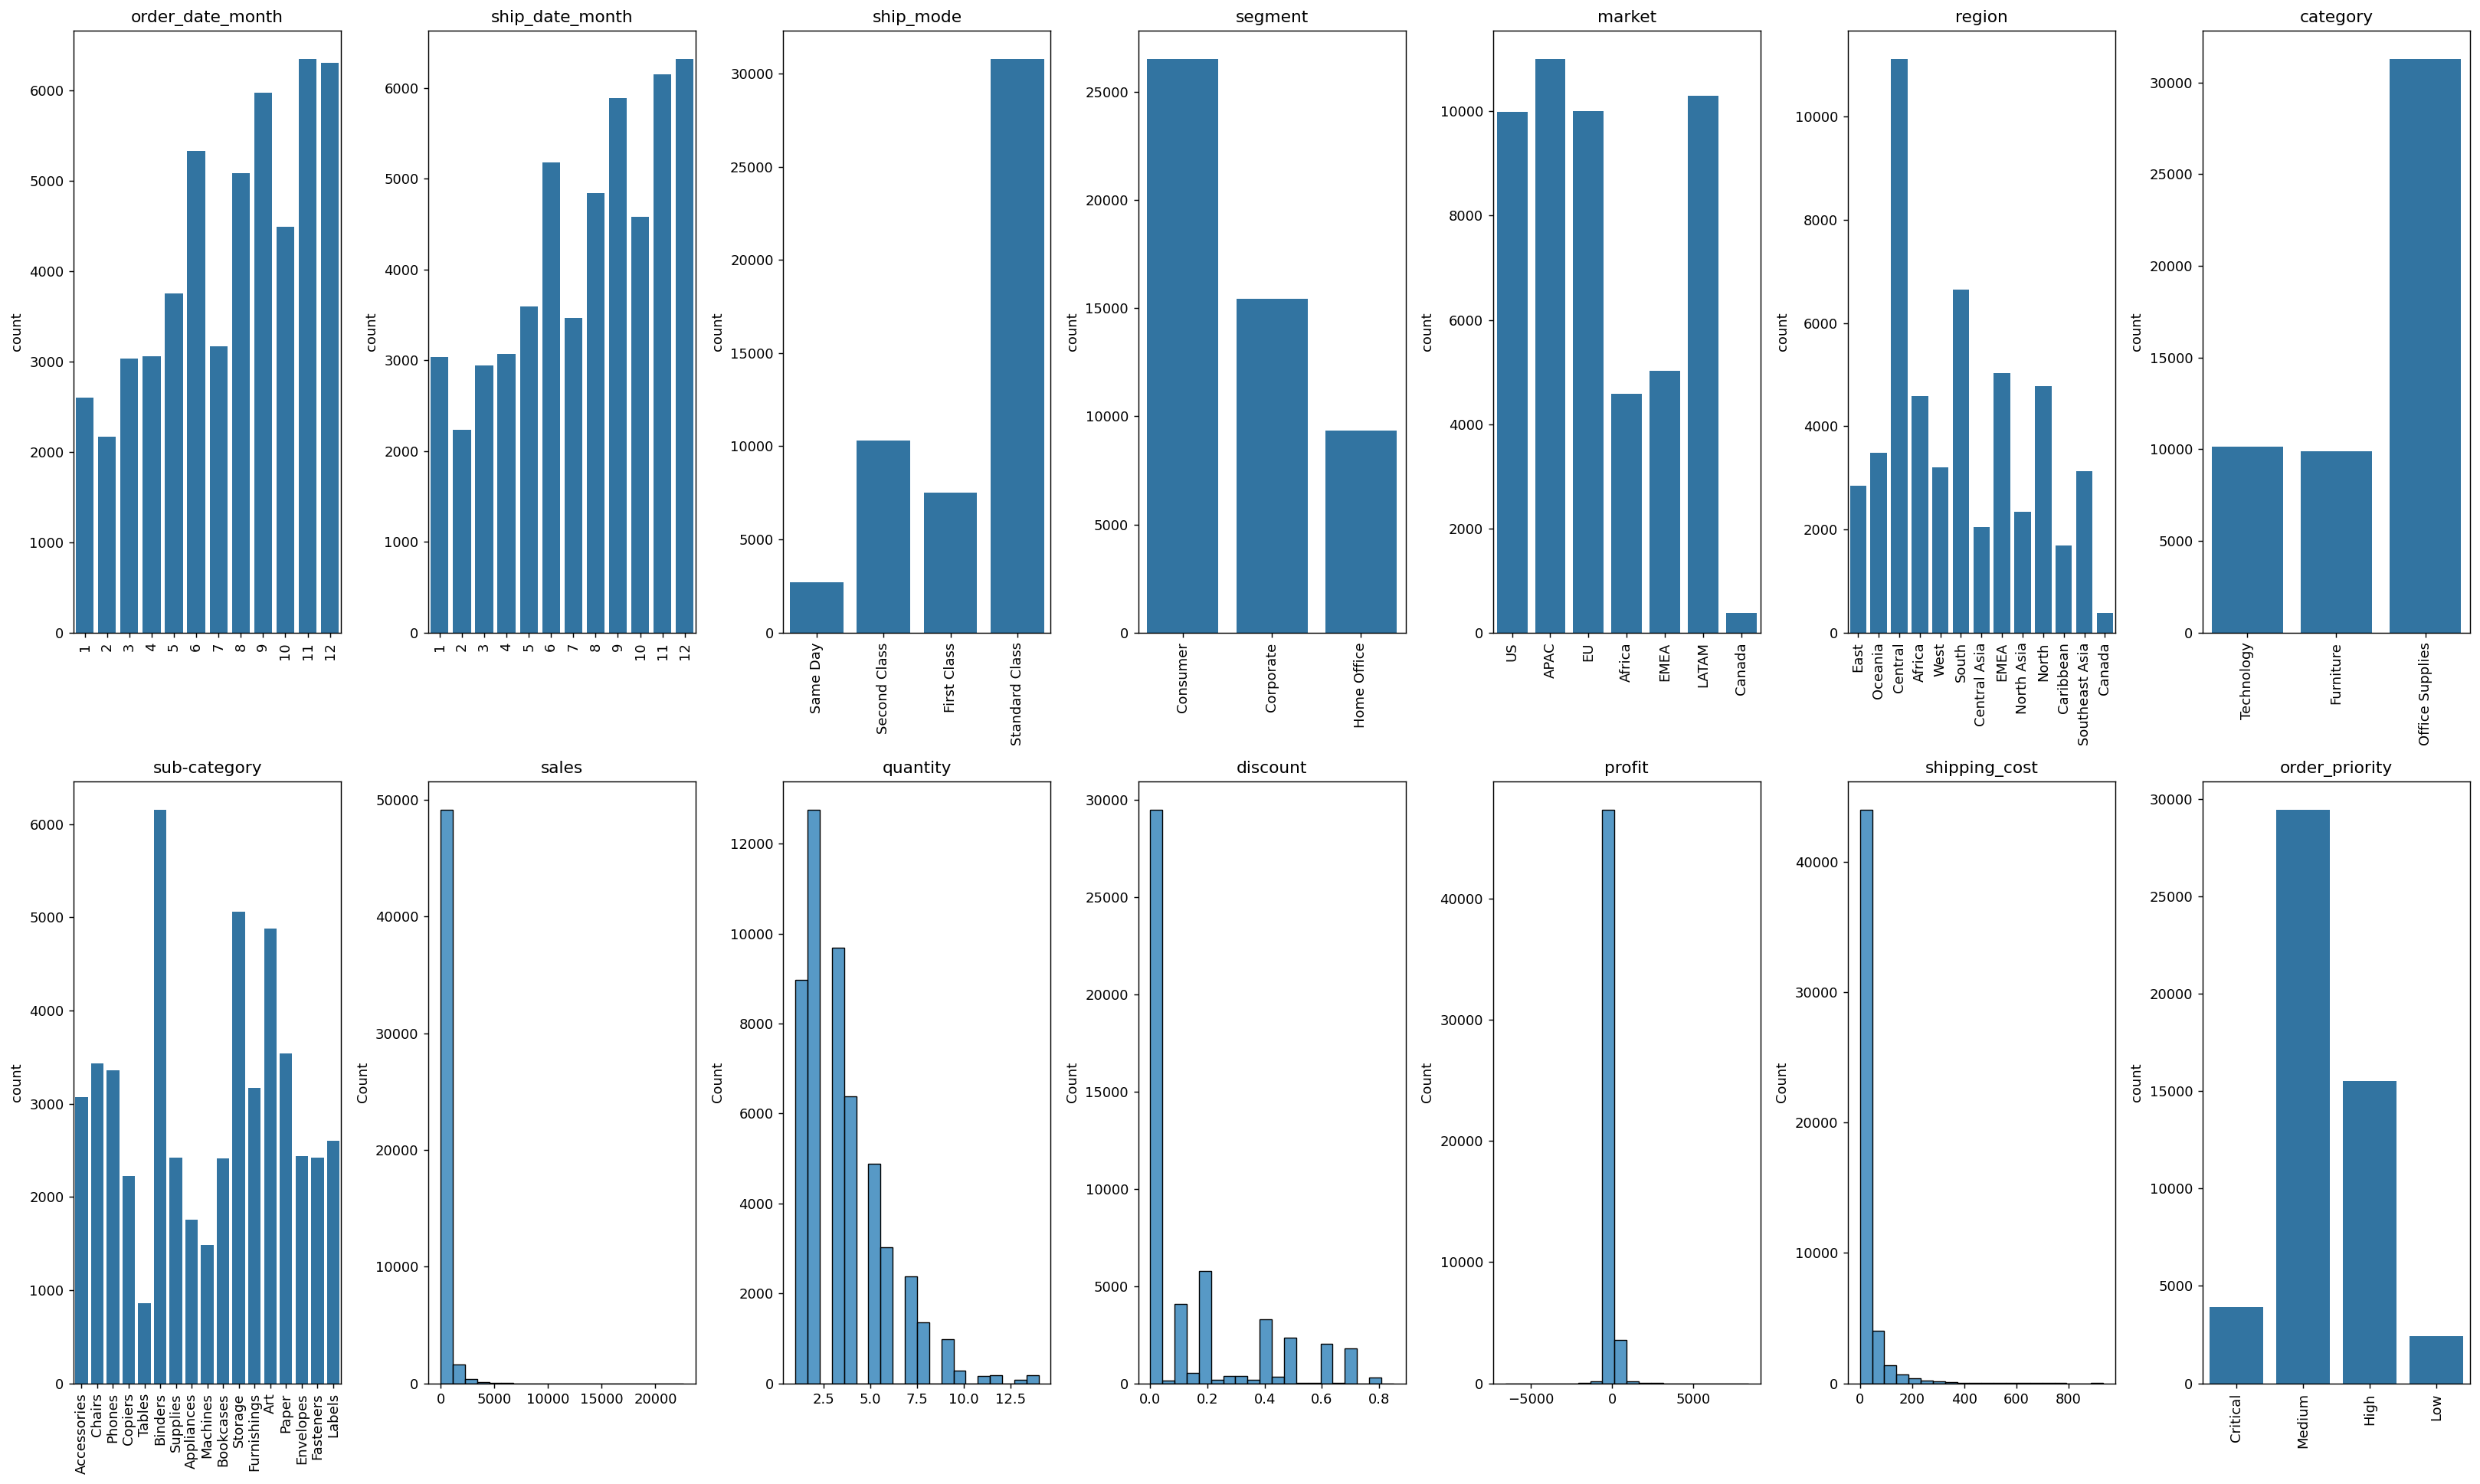

In [40]:
plot_col(data = df, x = df.columns.drop("country"))

Vemos que las ventas se concentran en invierno, y que sobretodo se venden artículos de oficina a particulares. Además. las distribuciones en general no son normales, lo cual indica un alto número de outliers en nuestros datos.

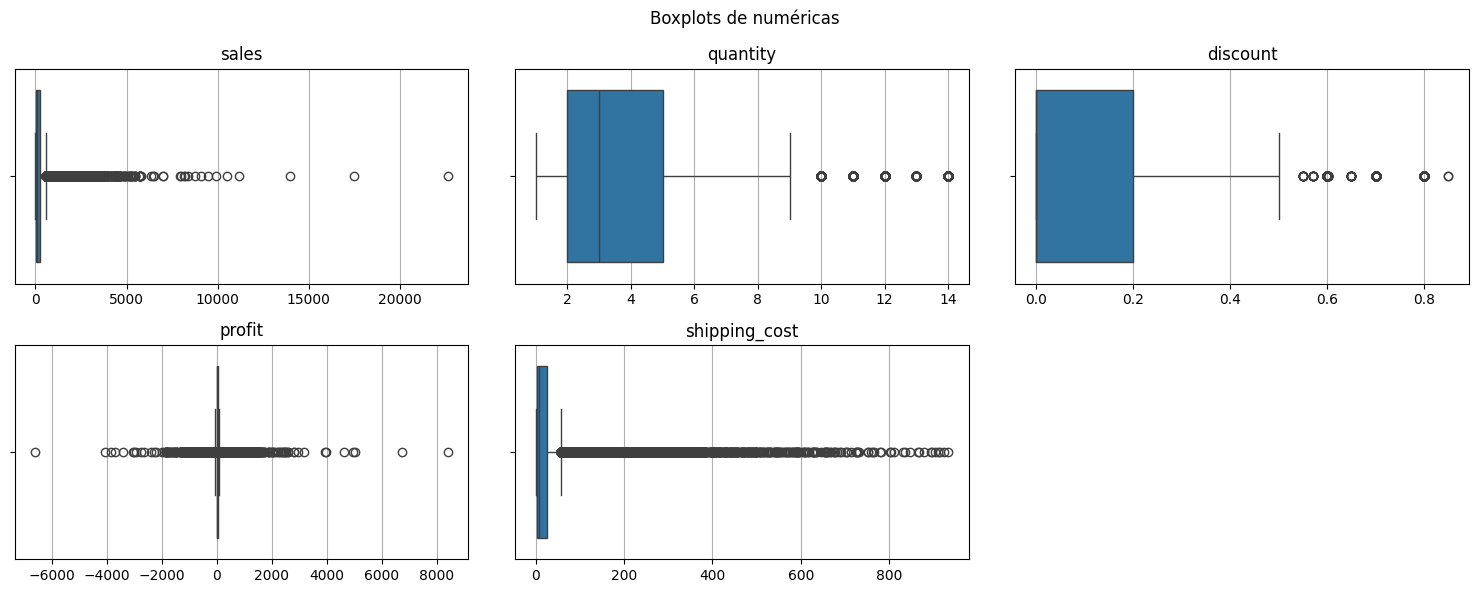

In [51]:
num_cols = df.select_dtypes("number").columns
ncols = math.ceil(len(num_cols)/2)
fig, axes = plt.subplots(nrows=2, ncols = ncols, figsize = (15,6))
axes = axes.flat
plt.suptitle("Boxplots de numéricas")
for i, col in enumerate(num_cols):
    axes[i].grid()
    sns.boxplot(data = df, x = col, ax = axes[i])
    axes[i].set_xlabel("")
    axes[i].set_title(col)
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show()
    

Vemos que las distribuciones no son normales, y los outliers univariados que encontramos suelen estar agrupados, a excepción de algunos muy atípicos.

También podemos observar las correlaciones que hay entre diferentes variables numéricas.

<Axes: >

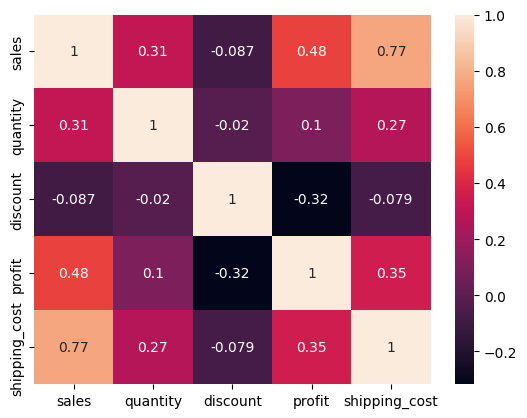

In [52]:
sns.heatmap(df[num_cols].corr(), annot=True)

Podemos ver una fuerte correlación entre ``sales`` y ``shipping_cost``que podría indicar que mayores ventas suelen implicar mayor costo de envío. Además, los descuentos tienen un impacto negativo en la rentabilidad. Por otro lado ``quantity`` muestra poca relación con otras variables, lo que sugiere que el volumen vendido no es un factor que influya mucho en el beneficio o los costos.

In [ ]:
df.to_pickle("../datos/clean.pkl")